**DeFi Yield Data Visualization**

This script will be creating 5 charts that will go onto the yield analysis part of the SoDeFi website. The charts are as follows:

1) 7 day rolling APY across all stablecoin pools (3 months data)
2) 7 day rolling APY across all ETH pools (3 months data) and 7 day rolling ETH LSD pools (3 months data)
3) Boxplot of the current 7 day APY across 10 largest blockchains (stablecoin pools)
4) Boxplot of the current 7 day APY across 25 largest projects
5) Joint plot visualizing all pools and their 7 day APY and TVL

In [1]:
# Import libraries and dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from datetime import timedelta

data = pd.read_csv(r'/Users/karolk/Python_Work/Data_Sets/Global_Data/DeFi_Global_DB.csv', index_col=0)
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:,.2f}'.format

# making sure date is in datetime format
data['date'] = pd.to_datetime(data['date'])



In [2]:
# cleaning the data by removing all pools with TVL of 0 or APY of 0
data = data[(data['tvlUsd'] > 0) & (data['apy'] > 0)]

# create a new column which shows True if symbol column contains 'eth' in the string and 'ilRisk' is equal to 'no'
data['eth_one_sided'] = np.where((data['symbol'].str.contains('eth', case=False, na=False)) & (data['ilRisk'] == 'no'), True, False)

# set the date column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# list with all liquid stakers
liquid_stakers = ['lido', 'rocket-pool', 'coinbase-wrapped-staked-eth', 'stakewise', 'frax-ether']

# create a new column where 'liquid_staker' is True if the project is in the liquid_stakers list
data['liquid_staker'] = np.where(data['project'].isin(liquid_stakers), True, False)

# sort the data table by pool and by date
data = data.sort_values(['pool', 'date'], ascending=[True, True]).reset_index(drop=True)

# create a new column which would the average APY over the last 7 days using the 'apy' column
data['apyMean7d'] = data.groupby('pool')['apy'].transform(lambda x: x.rolling(7, 1).mean())

# keep only the columns needed for the analysis: 'chain', 'project', 'pool', 'symbol', 'tvlUsd', 'apy', 'apyMean7d', 'date', 'eth_one_sided', 'liquid_staker', 'stablecoin'
data = data[['chain', 'project', 'pool', 'symbol', 'stablecoin','tvlUsd', 'apy', 'apyMean7d', 'date', 'eth_one_sided', 'liquid_staker']]

# selecting only the last 3 months of data
today = pd.to_datetime('today')
start_date = today - timedelta(days=90)
data = data[data['date'] >= start_date]


In [3]:
#data


In [4]:
# preparing the required cuts of data for all charts

# creating dataframe with all stablecoin pools
stablecoin_pools = data[data['stablecoin'] == True]

# selecting only stablecoin pools with over 3M in TVL
stablecoin_pools = stablecoin_pools[stablecoin_pools['tvlUsd'] > 3000000]

# create a new column in stablecoin_pools which calculated the z-score of the 7 day APY
stablecoin_pools['z_score'] = (stablecoin_pools['apyMean7d'] - stablecoin_pools['apyMean7d'].mean())/stablecoin_pools['apyMean7d'].std(ddof=0)

# remove all rows where z-score is greater than 3
stablecoin_pools = stablecoin_pools[stablecoin_pools['z_score'] < 3]

# remove all rows where z-score is less than -3
stablecoin_pools = stablecoin_pools[stablecoin_pools['z_score'] > -3]

# creating dataframe with all ETH pools by selecting all pools where eth_one_sided is True
eth_pools = data[data['eth_one_sided'] == True]

# remove all eth pools with TVL of less than 30M
eth_pools = eth_pools[eth_pools['tvlUsd'] > 30000000]

# create a new column in eth_pools which calculated the z-score of the 7 day APY
eth_pools['z_score'] = (eth_pools['apyMean7d'] - eth_pools['apyMean7d'].mean())/eth_pools['apyMean7d'].std(ddof=0)

# remove all rows where z-score is greater than 3 in eth_pools
eth_pools = eth_pools[eth_pools['z_score'] < 3]

# selecting only stablecoin pools data for latest date
stablecoin_pools_latest = stablecoin_pools[stablecoin_pools['date'] == stablecoin_pools['date'].max()]

# creating a dataframe with 10 largest blockchains by TVL in the stabelcoin latest data
stablecoin_pools_latest_10 = stablecoin_pools_latest.groupby('chain').sum('tvlUsd').sort_values('tvlUsd', ascending=False).head(10).reset_index()

# creating a list of largest blockchains from stablecoin_pools_latest_10
stablecoin_pools_latest_10_list = stablecoin_pools_latest_10['chain'].to_list()

# creating a pivot table with the 25 largest projects by TVL in the stablecoin latest data
stablecoin_pools_latest_25 = stablecoin_pools_latest.pivot_table(index='project', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(25).reset_index()

# creating a list of largest projects from stablecoin_pools_latest_25
stablecoin_pools_latest_25_list = stablecoin_pools_latest_25['project'].to_list()

# creating a new dataframe that has the stablecoin pools data latest for only the 10 largest blockchains
stablecoin_pools_latest_10 = stablecoin_pools_latest[stablecoin_pools_latest['chain'].isin(stablecoin_pools_latest_10_list)]

# creating a new dataframe that has the stablecoin pools data latest for only the 25 largest projects
stablecoin_pools_latest_25 = stablecoin_pools_latest[stablecoin_pools_latest['project'].isin(stablecoin_pools_latest_25_list)]

In [5]:
# creating data for non-stablecoin pools

# preparing the required cuts of data for all charts

# creating dataframe with all stablecoin pools
non_stable_pools = data[data['stablecoin'] == False]

# selecting only non-stablecoin pools with over 5M in TVL
non_stable_pools = non_stable_pools[non_stable_pools['tvlUsd'] > 5000000]

# create a new column in non_stable_pools which calculated the z-score of the 7 day APY
non_stable_pools['z_score'] = (non_stable_pools['apyMean7d'] - non_stable_pools['apyMean7d'].mean())/non_stable_pools['apyMean7d'].std(ddof=0)

# remove all rows where z-score is greater than 3
non_stable_pools = non_stable_pools[non_stable_pools['z_score'] < 3]

# remove all rows where z-score is less than -3
non_stable_pools = non_stable_pools[non_stable_pools['z_score'] > -3]

# selecting only stablecoin pools data for latest date
non_stable_pools_latest = non_stable_pools[non_stable_pools['date'] == non_stable_pools['date'].max()]

# creating a dataframe with 10 largest blockchains by TVL in the stabelcoin latest data
non_stable_pools_latest_10 = non_stable_pools_latest.groupby('chain').sum('tvlUsd').sort_values('tvlUsd', ascending=False).head(10).reset_index()

# creating a list of largest blockchains from non_stable_pools_latest_10
non_stable_pools_latest_10_list = non_stable_pools_latest_10['chain'].to_list()

# creating a pivot table with the 25 largest projects by TVL in the stablecoin latest data
non_stable_pools_latest_25 = non_stable_pools_latest.pivot_table(index='project', values='tvlUsd', aggfunc='sum').sort_values('tvlUsd', ascending=False).head(25).reset_index()

# creating a list of largest projects from non_stable_pools_latest_25
non_stable_pools_latest_25_list = non_stable_pools_latest_25['project'].to_list()

# creating a new dataframe that has the stablecoin pools data latest for only the 10 largest blockchains
non_stable_pools_latest_10 = non_stable_pools_latest[non_stable_pools_latest['chain'].isin(non_stable_pools_latest_10_list)]

# creating a new dataframe that has the stablecoin pools data latest for only the 25 largest projects
non_stable_pools_latest_25 = non_stable_pools_latest[non_stable_pools_latest['project'].isin(non_stable_pools_latest_25_list)]

In [6]:
# preparing all themes and visual settings for the charts

#importing image for watermark
img = Image.open(r'/Users/karolk/Python_Work/Data_Sets/logo.png')

#creating string that says "Data updated as of: mmm dd yyyy"
date = data['date'].max()
date = pd.to_datetime(date)
date = date.strftime('%b %d %Y')
date = 'Data updated as of: ' + date

#setting theme for all plots
sns.set_theme(style="ticks", context='talk')

#setting up font for all plots
fontpath = '/System/Library/Fonts/Optima.ttc'
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()

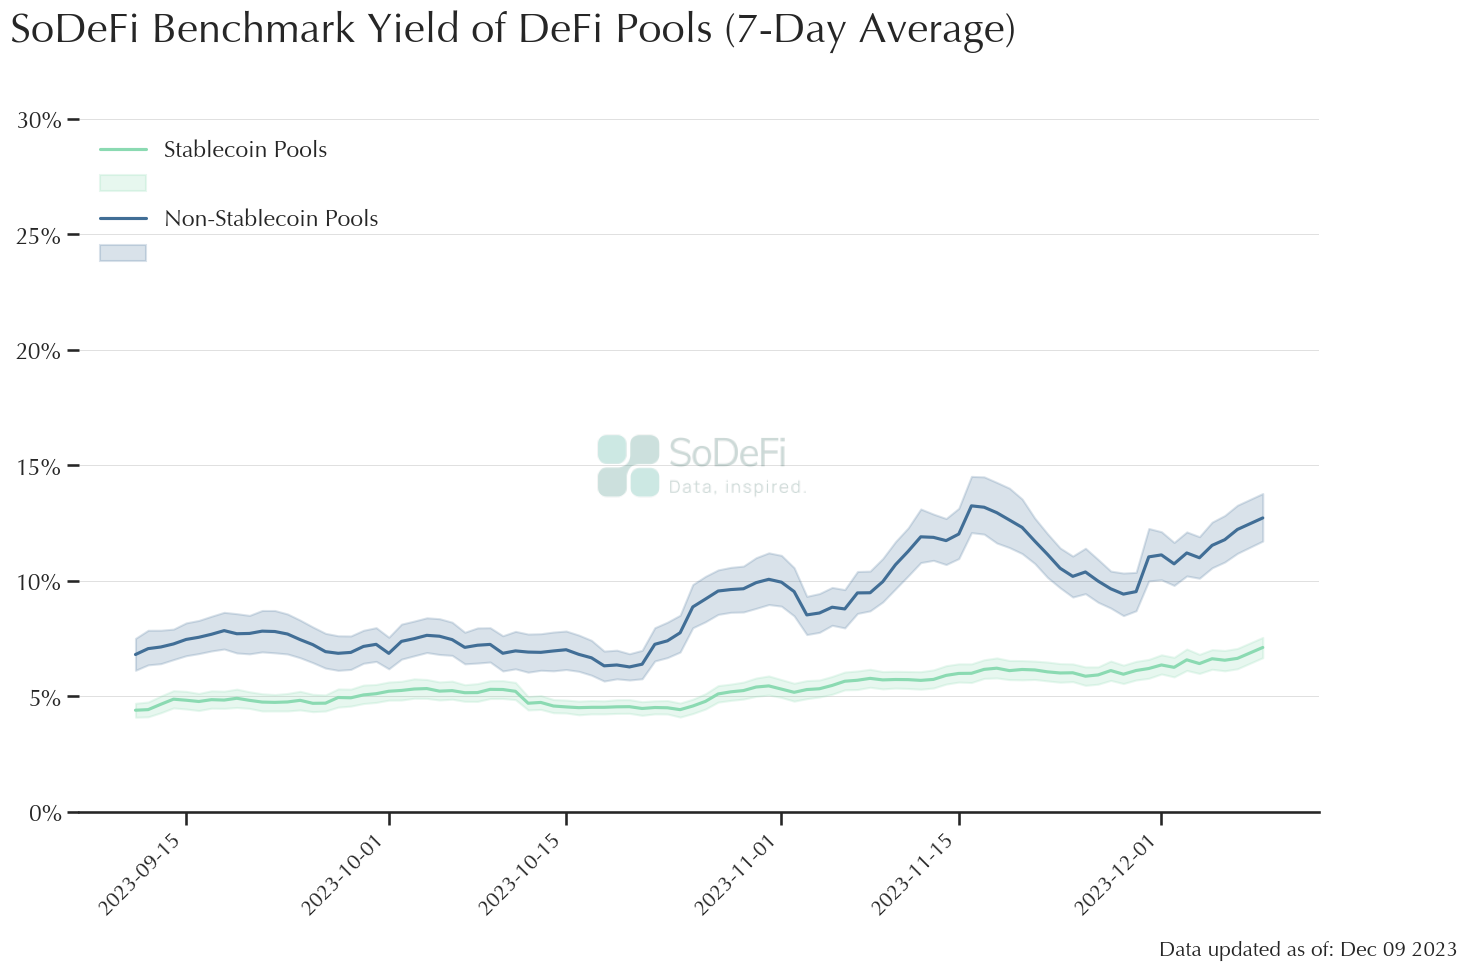

In [7]:
# creating exhibit 5 - line plot of 7 - day yield for all stablecoin pools

#set the color palette
sns.set_palette('mako_r')

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#plot the line chart
ax = sns.lineplot(x='date', y='apyMean7d', data=stablecoin_pools, errorbar=('ci', 75))
sns.lineplot(x='date', y='apyMean7d', data=non_stable_pools, errorbar=('ci', 75), color='#416E96')

#despine the chart
sns.despine(left=True)

#adding gridlines at 0, 5, 10, 15, 20, 25, 30. the color of the gridlines is set to light grey
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)

#set title and labels for the chart
plt.title('SoDeFi Benchmark Yield of DeFi Pools (7-Day Average)',
          size=30, weight='bold', x=0.35, y=1.1)
plt.xlabel(None)
plt.ylabel(None)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adjusting the y axis ticks scale from 0 to 30%
plt.yticks([0, 5, 10, 15, 20, 25, 30],
          ['0%', '5%', '10%', '15%', '20%', '25%', '30%'])

#rotating the x-axis labels
plt.xticks(rotation=45, ha="right", size=15)

#adding a legend for the chart
plt.legend(['Stablecoin Pools', None, 'Non-Stablecoin Pools', None], ncol=1, loc="upper left", frameon=False)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#saving chart as png file
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/5.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

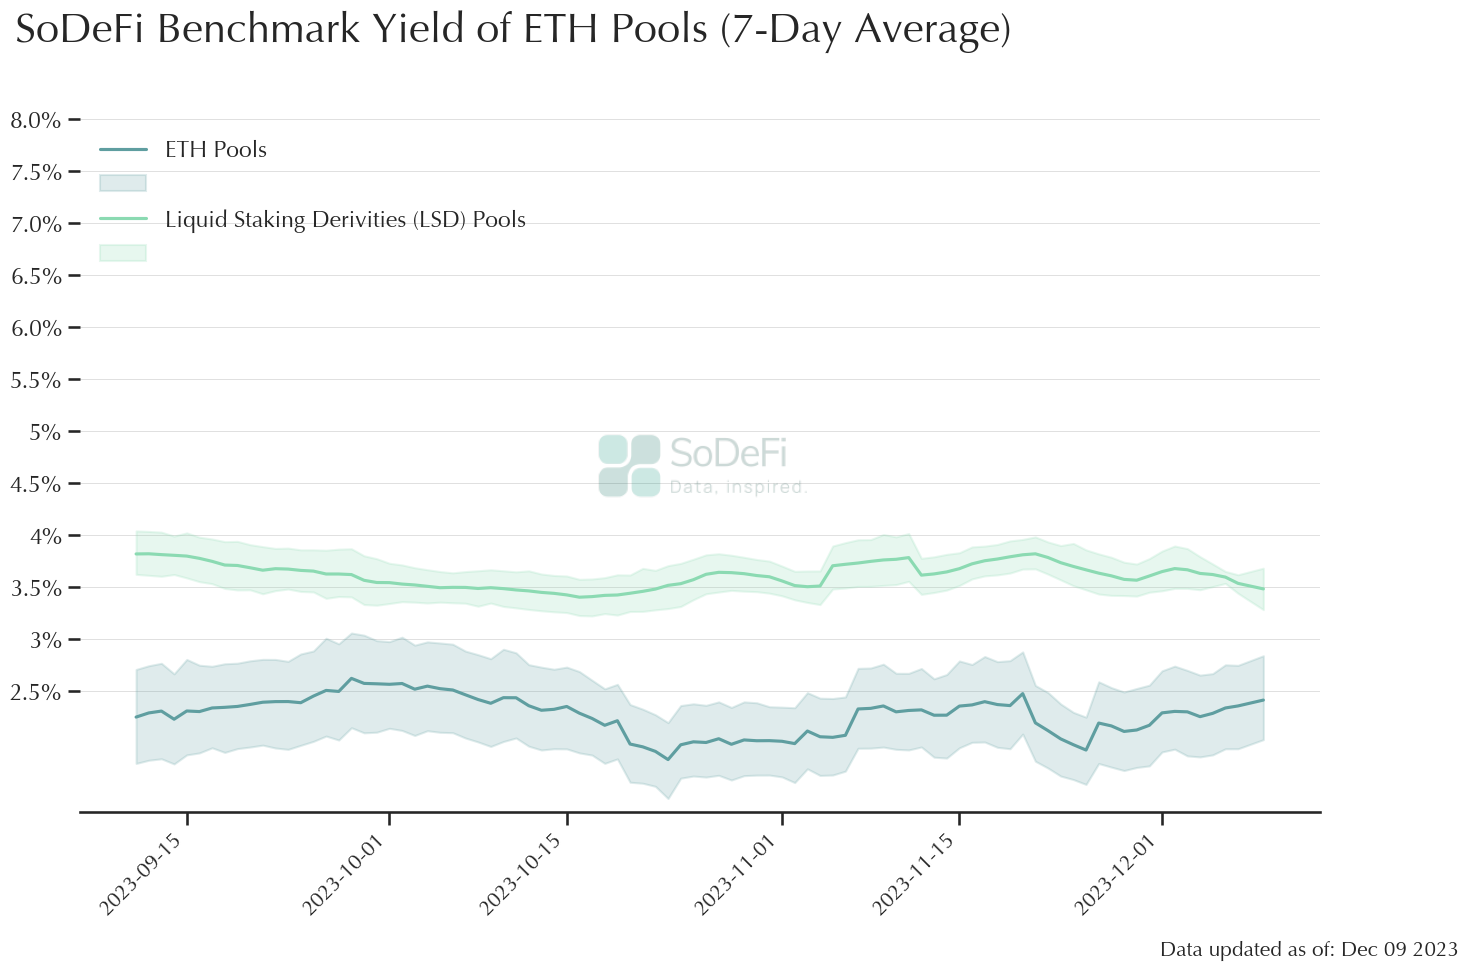

In [8]:
# creating exhibit 6 - line plot of 7 - day yield for ETH pools and LSD pools

#plot the total TVL by date
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#set the color palette
sns.set_palette('mako_r')

#plot the line chart
ax = sns.lineplot(x='date', y='apyMean7d', data=eth_pools[eth_pools['liquid_staker'] == False], errorbar=('ci', 75), color='cadetblue')
sns.lineplot(x='date', y='apyMean7d', data=eth_pools[eth_pools['liquid_staker'] == True], errorbar=('ci', 75))

#despine the chart
sns.despine(left=True)

#set title and labels for the chart
plt.title('SoDeFi Benchmark Yield of ETH Pools (7-Day Average)',
          size=30, weight='bold', x=0.35, y=1.1)
plt.xlabel(None)
plt.ylabel(None)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adding a legend for the chart
plt.legend(['ETH Pools', None,'Liquid Staking Derivities (LSD) Pools', None], ncol=1, loc="upper left", frameon=False)

#adjusting the y axis ticks scale
plt.yticks([2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0],
           ['2.5%', '3%', '3.5%', '4%', '4.5%', '5%', '5.5%', '6.0%', '6.5%', '7.0%', '7.5%', '8.0%'])

#rotating the x-axis labels
plt.xticks(rotation=45, ha="right", size=15)

# adding gridlines 
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8, alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#saving chart as png file
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/6.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

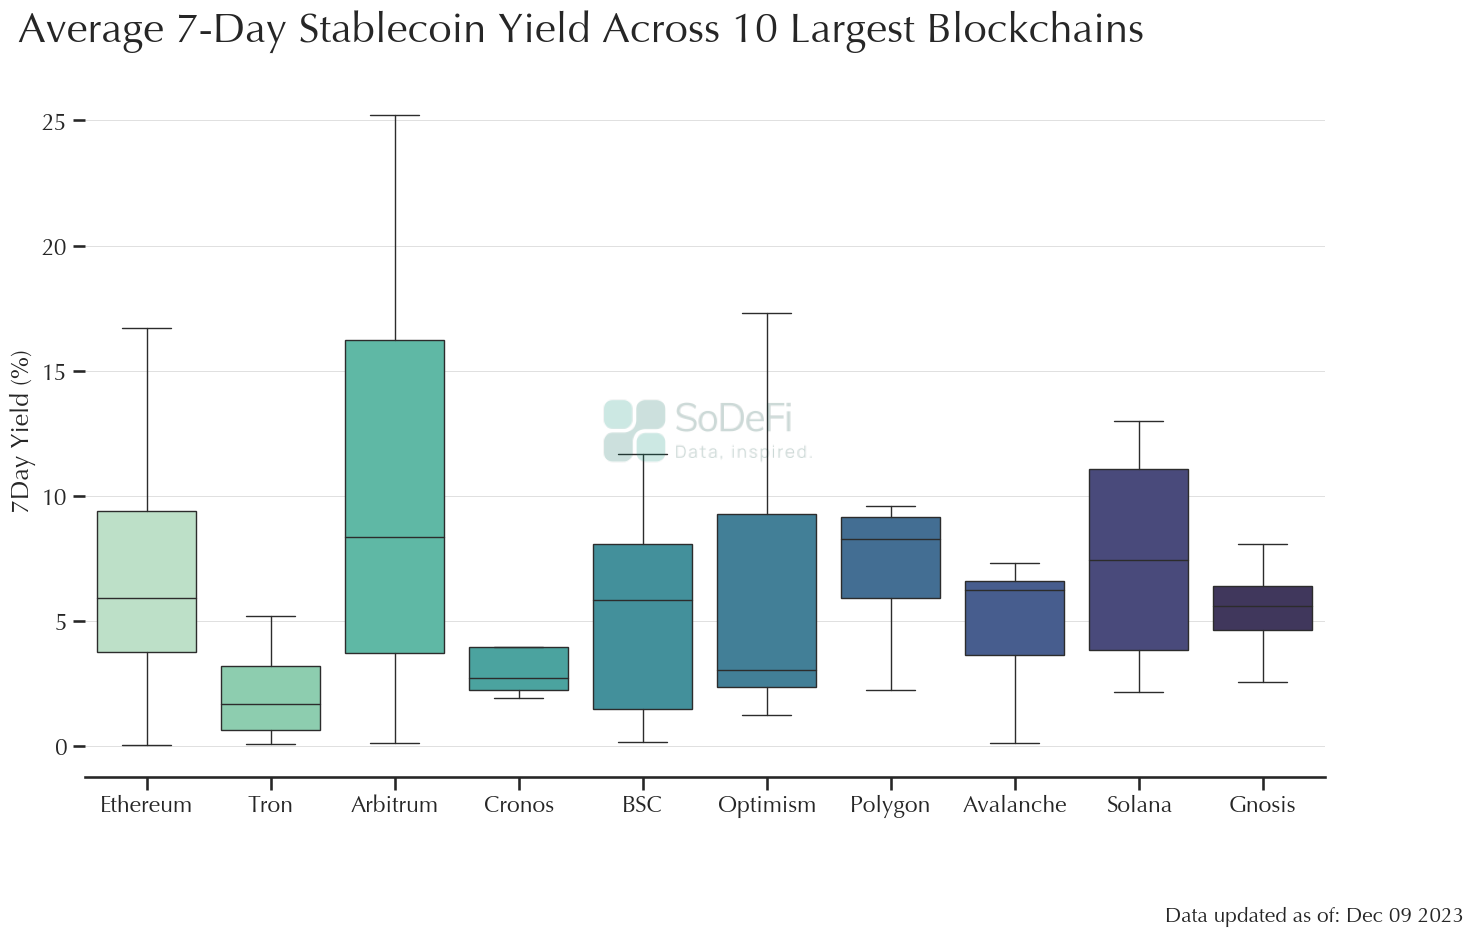

In [9]:
#setting figure and axis
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#setting color palatte for chart
sns.set_palette("mako_r",12)

#charting data
ax = sns.boxplot(x='chain', y='apyMean7d', data=stablecoin_pools_latest_10, order=stablecoin_pools_latest_10_list, sym='', linewidth=1)

#despine the chart
sns.despine(left=True, bottom=False)

#setting chart title and axis labels
ax.set_title('Average 7-Day Stablecoin Yield Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.4)
ax.set(xlabel =None,
       ylabel = '7Day Yield (%)')

#adding watermark
imagebox = OffsetImage(img, zoom=0.8,alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adjusting the tick marks
plt.xticks(rotation=0)

#adding gridlines
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)

#saving plot
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/7.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

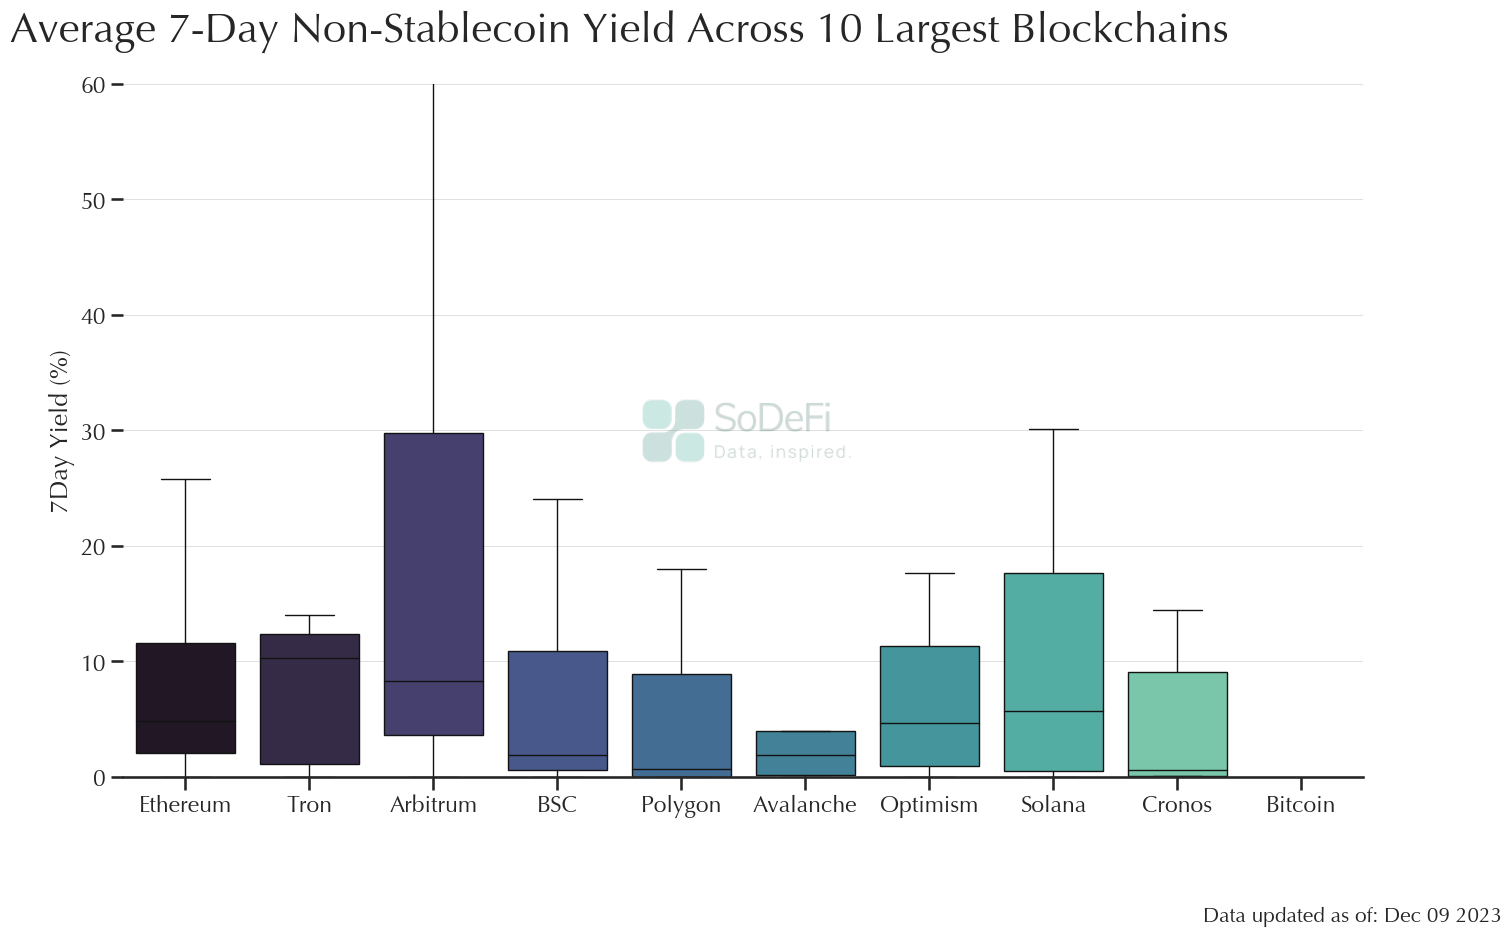

In [10]:
#setting figure and axis
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#setting color palatte for chart
sns.set_palette("mako",10)

#charting data
ax = sns.boxplot(x='chain', y='apyMean7d', data=non_stable_pools_latest_10, order=non_stable_pools_latest_10_list, sym='', linewidth=1)

#despine the chart
sns.despine(left=True, bottom=False)

#adding gridlines
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)

#adjust the y axis scale to be between 0 and 30%
plt.ylim(0, 60)

#setting chart title and axis labels
ax.set_title('Average 7-Day Non-Stablecoin Yield Across 10 Largest Blockchains',
             y=1.05, size=30, weight='bold', x=0.4)
ax.set(xlabel =None,
       ylabel = '7Day Yield (%)')

#adding watermark
imagebox = OffsetImage(img, zoom=0.8,alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#adjusting the tick marks
plt.xticks(rotation=0)

#saving plot
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/10.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

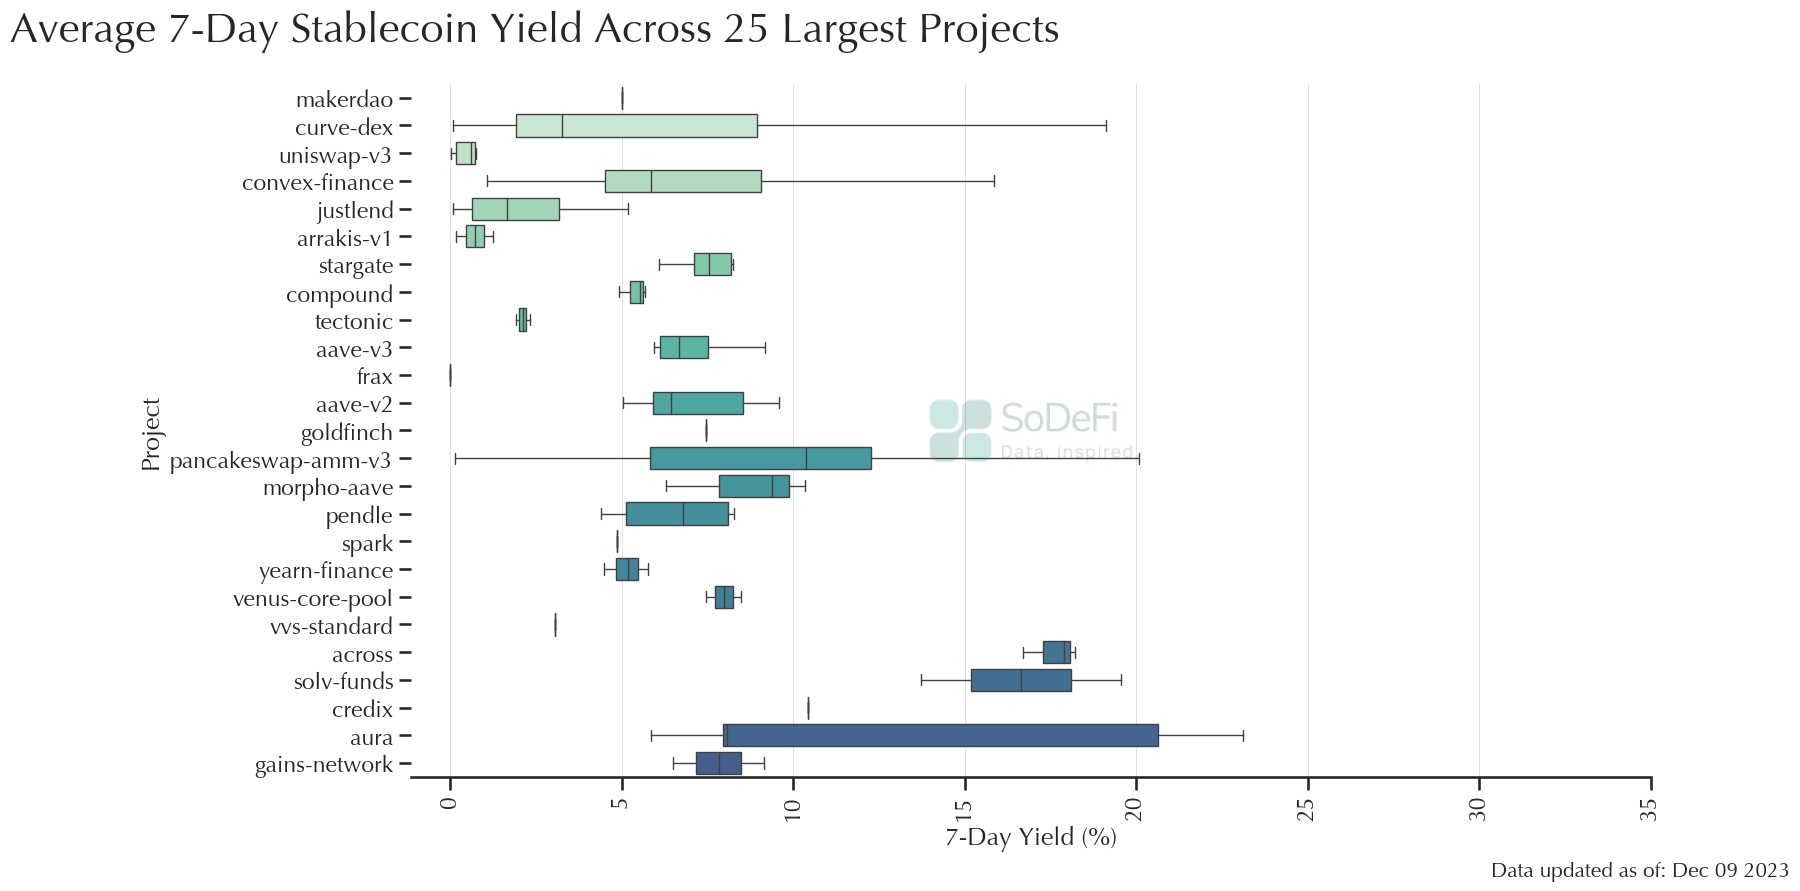

In [11]:
# creating exhibit 8 - boxplot of 25 largest protocols

#setting figure and axis
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#setting color palatte for chart
sns.set_palette("mako_r",40)

#charting data
ax = sns.boxplot(x='apyMean7d', y='project', data=stablecoin_pools_latest_25, sym='',
                 order=stablecoin_pools_latest_25_list, linewidth=1)

#setting chart title and axis labels
ax.set_title('Average 7-Day Stablecoin Yield Across 25 Largest Projects',
             y=1.05, size=30, weight='bold', x=0.1)
ax.set(xlabel ='7-Day Yield (%)',
       ylabel = 'Project')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, 0, date, fontsize=15, transform=plt.gcf().transFigure)

#setting the tick marks for x-axis in 5% increments
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35], ['0', '5', '10', '15', '20', '25', '30', '35'])

#adding gridlines
plt.grid(axis='x', color='lightgrey', linestyle='-', linewidth=0.5)

#despining chart
sns.despine(left=True, bottom=False)


#adding watermark
imagebox = OffsetImage(img, zoom=0.8,alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#adjusting the tick marks
plt.xticks(rotation=90)

#saving plot
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/8.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

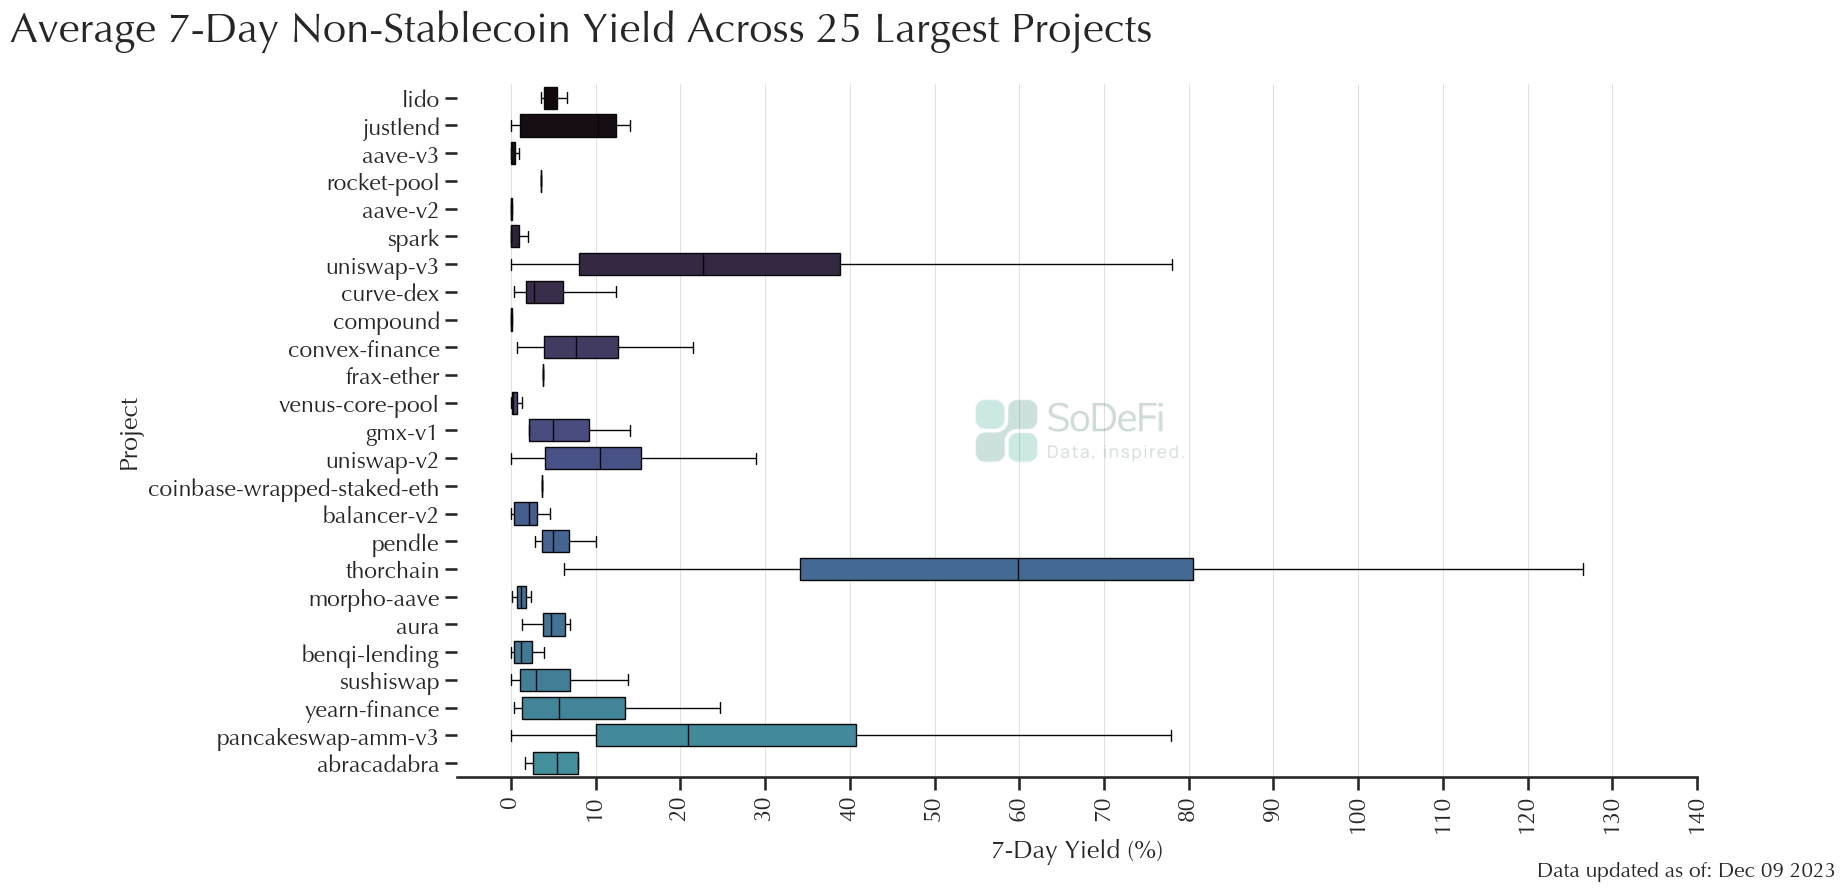

In [12]:
# creating exhibit 8 - boxplot of 25 largest protocols

#setting figure and axis
fig, ax = plt.subplots()
ax.figure.set_size_inches(16, 9)

#setting color palatte for chart
sns.set_palette("mako",40)

#charting data
ax = sns.boxplot(x='apyMean7d', y='project', data=non_stable_pools_latest_25, sym='',
                 order=non_stable_pools_latest_25_list, linewidth=1)

#setting chart title and axis labels
ax.set_title('Average 7-Day Non-Stablecoin Yield Across 25 Largest Projects',
             y=1.05, size=30, weight='bold', x=0.1)
ax.set(xlabel ='7-Day Yield (%)',
       ylabel = 'Project')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, 0, date, fontsize=15, transform=plt.gcf().transFigure)

#setting the tick marks for x-axis in 10% increments
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140], ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90', '100','110', '120', '130', '140'])

#despining chart
sns.despine(left=True, bottom=False)

#adding gridlines
plt.grid(axis='x', color='lightgrey', linestyle='-', linewidth=0.5)

#adding watermark
imagebox = OffsetImage(img, zoom=0.8,alpha=0.2)
imagebox.image.axes = ax
ao = AnnotationBbox(imagebox, (0.5, 0.5), xycoords='axes fraction', bboxprops={'lw':0})
ao.patch.set_alpha(0)
ax.add_artist(ao)

#adjusting the tick marks
plt.xticks(rotation=90)

#saving plot
fig.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/11.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

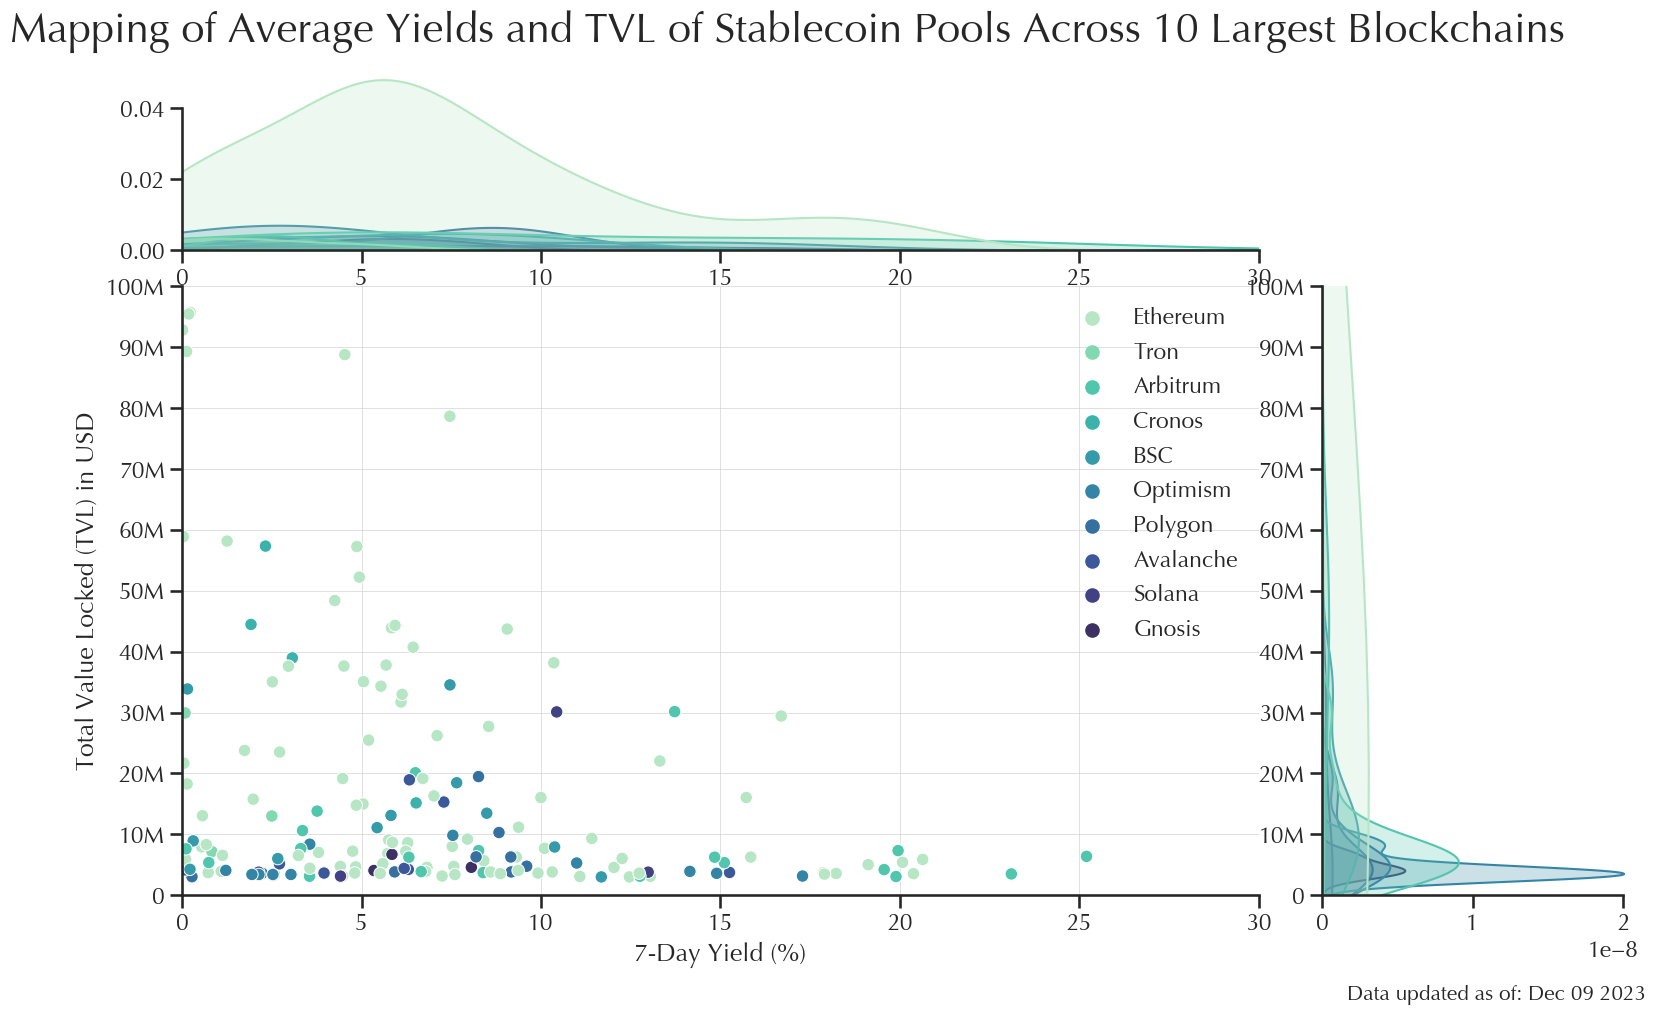

In [13]:
# creating exhibit 9 - rel plot between TVL and 7-day yield

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
g = sns.jointplot(x='apyMean7d', y='tvlUsd', data=stablecoin_pools_latest_10,
                  height=15, ratio=3, space=0.2, hue='chain', hue_order=stablecoin_pools_latest_10_list,
                  xlim=(0, 30), ylim=(2000000, 100000000))


#setting the title and labels
g.fig.suptitle('Mapping of Average Yields and TVL of Stablecoin Pools Across 10 Largest Blockchains',
               y=1.05, size=30, weight='bold', x=0.45)
plt.xlabel('7-Day Yield (%)')
plt.ylabel('Total Value Locked (TVL) in USD')

#adding gridlines
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)
plt.grid(axis='x', color='lightgrey', linestyle='-', linewidth=0.5)

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#set the legend location
plt.legend(loc='best', frameon=False)

#set size of chart
g.fig.set_size_inches(16, 9)

#adjusting the tick marks
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], ['0','10M', '20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M', '100M'])
plt.xticks([0, 5, 10, 15, 20, 25, 30], ['0', '5', '10', '15', '20', '25', '30'])

#despine the plot
sns.despine(trim=True, offset=0)

#save the figure
g.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/9.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()

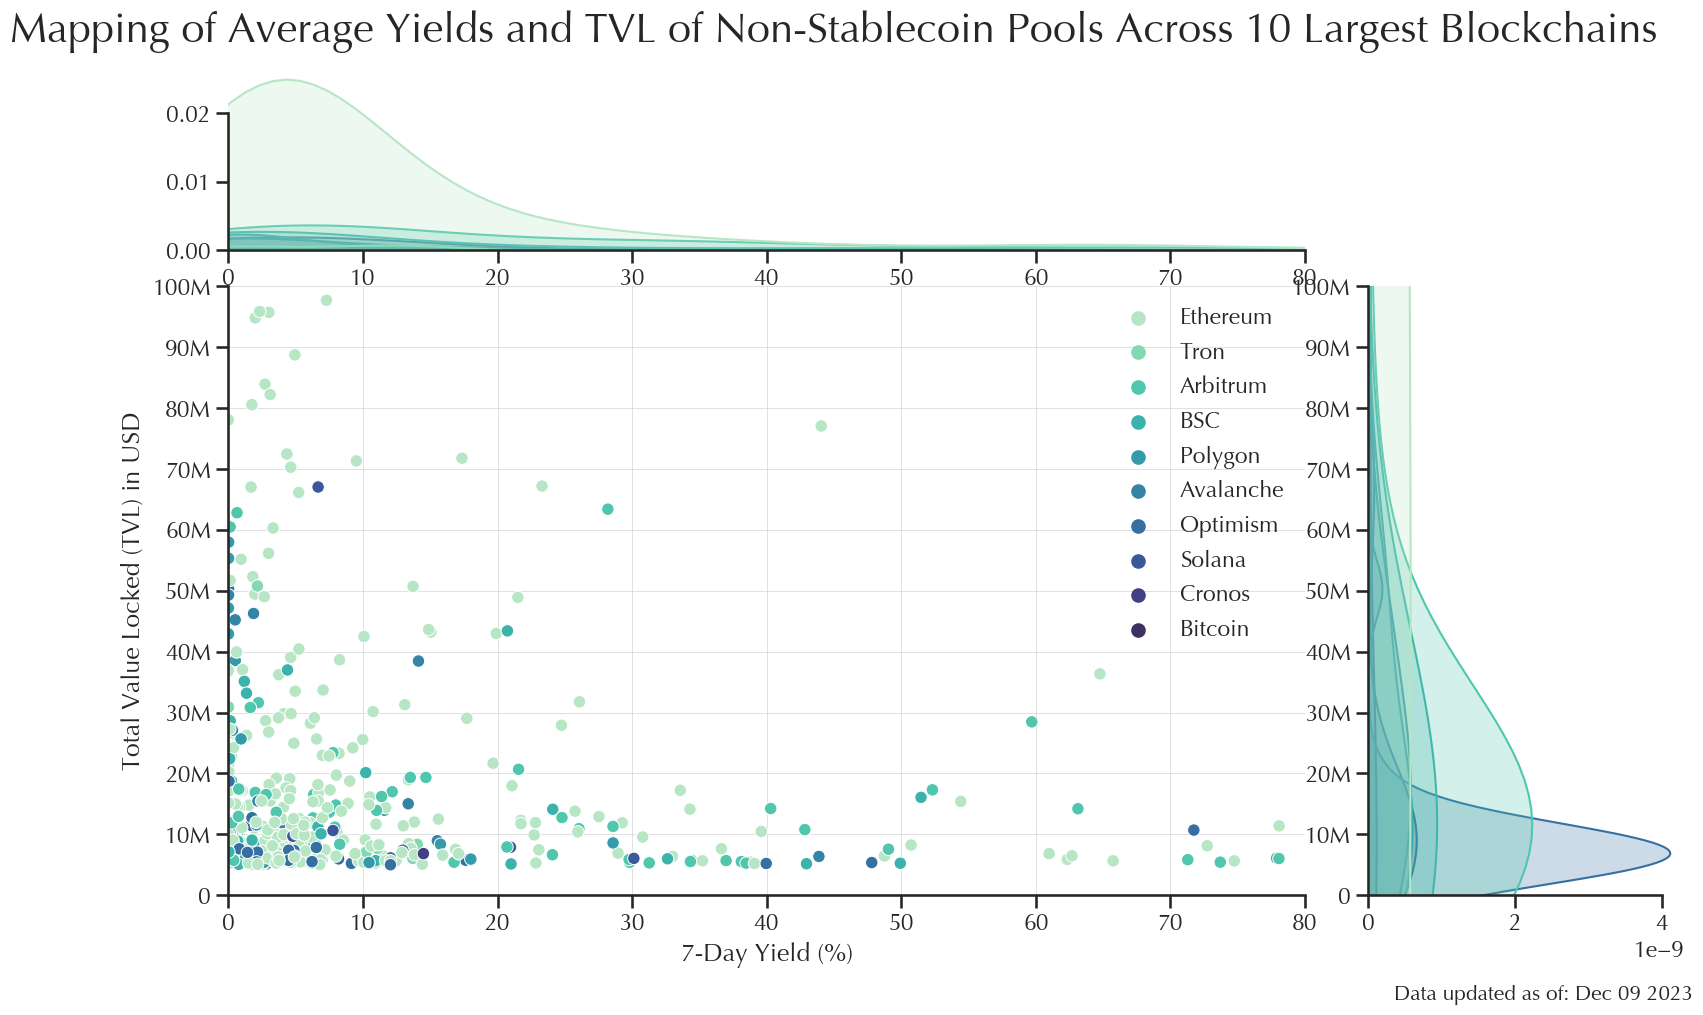

In [14]:
# creating exhibit 9 - rel plot between TVL and 7-day yield

#setting color palatte for chart
sns.set_palette("mako_r",12)

#create chart
g = sns.jointplot(x='apyMean7d', y='tvlUsd', data=non_stable_pools_latest_10,
                  height=15, ratio=3, space=0.2, hue='chain', hue_order=non_stable_pools_latest_10_list,
                  xlim=(0, 80), ylim=(2000000, 100000000))


#setting the title and labels
g.fig.suptitle('Mapping of Average Yields and TVL of Non-Stablecoin Pools Across 10 Largest Blockchains',
               y=1.05, size=30, weight='bold', x=0.45)
plt.xlabel('7-Day Yield (%)')
plt.ylabel('Total Value Locked (TVL) in USD')

#adding a string of when data was updated to the  right bottom corner of exhibit
plt.text(0.8, -0.05, date, fontsize=15, transform=plt.gcf().transFigure)

#set the legend location
plt.legend(loc='best', frameon=False)

#adding gridlines
plt.grid(axis='y', color='lightgrey', linestyle='-', linewidth=0.5)
plt.grid(axis='x', color='lightgrey', linestyle='-', linewidth=0.5)

#adding the x and y axis ticks
plt.yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000, 100000000], ['0','10M', '20M', '30M', '40M', '50M', '60M', '70M', '80M', '90M', '100M'])
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80], ['0', '10', '20', '30', '40', '50', '60', '70', '80'])

#set size of chart
g.fig.set_size_inches(16, 9)

#adjusting the tick marks

#despine the plot
sns.despine(trim=True, offset=0)

#save the figure
g.savefig('/Users/karolk/Python_Work/DeFi_Viz/Figures/12.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
plt.cla()
plt.clf()
plt.close()